# Lab 0. Tanh

In [23]:
# download the packeges
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

###  0.1 Task

Swap the LeakyReLUs for Tanh. Then run again the experiment and report accuracy on
test set.

In [24]:
# Download and prepare CIFAR-10 dataset

transform = transforms.ToTensor()
train_dataset = CIFAR10(root='./cifar-10-batches-py', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./cifar-10-batches-py', train=False, download=True, transform=transform)

print("Train samples:", len(train_dataset), "Test samples:", len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
Train samples: 50000 Test samples: 10000


In [25]:
# Device configuration
device = torch.device("cpu")

In [26]:
# Hyperparameters
num_epochs = 10
batch_size = 128
learning_rate = 0.0001

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [27]:
# Define a CNN with Tanh activations (instead of LeakyReLU)
class TanhCNN(nn.Module):
    def __init__(self):
        super(TanhCNN, self).__init__()
        self.features = nn.Sequential(
            # First convolution block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Second convolution block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.Tanh(),
            nn.Linear(256, 10)  # CIFAR-10 has 10 classes
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = TanhCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [28]:
# Setup TensorBoard writer (logs will be saved in 'runs/sgd_tanh_experiment')
writer = SummaryWriter('runs/sgd_tanh_experiment')

# Lists to record loss and accuracy per epoch (optional for plotting)
train_loss_history = []
test_loss_history = []
test_accuracy_history = []

# Training loop with evaluation and TensorBoard logging
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * images.size(0)
    
    epoch_train_loss = running_train_loss / len(train_dataset)
    train_loss_history.append(epoch_train_loss)
    writer.add_scalar('Loss/train', epoch_train_loss, epoch)
    
    # Evaluation phase
    model.eval()
    running_test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_test_loss = running_test_loss / len(test_dataset)
    test_loss_history.append(epoch_test_loss)
    test_accuracy = 100 * correct / total
    test_accuracy_history.append(test_accuracy)
    
    writer.add_scalar('Loss/test', epoch_test_loss, epoch)
    writer.add_scalar('Accuracy/test', test_accuracy, epoch)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, "
          f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

writer.close()

Epoch [1/10], Train Loss: 2.3018, Test Loss: 2.3005, Test Accuracy: 9.50%
Epoch [2/10], Train Loss: 2.2995, Test Loss: 2.2983, Test Accuracy: 9.71%
Epoch [3/10], Train Loss: 2.2973, Test Loss: 2.2963, Test Accuracy: 9.96%
Epoch [4/10], Train Loss: 2.2954, Test Loss: 2.2944, Test Accuracy: 10.33%
Epoch [5/10], Train Loss: 2.2936, Test Loss: 2.2926, Test Accuracy: 11.40%
Epoch [6/10], Train Loss: 2.2919, Test Loss: 2.2909, Test Accuracy: 14.33%
Epoch [7/10], Train Loss: 2.2902, Test Loss: 2.2893, Test Accuracy: 15.75%
Epoch [8/10], Train Loss: 2.2886, Test Loss: 2.2877, Test Accuracy: 15.96%
Epoch [9/10], Train Loss: 2.2870, Test Loss: 2.2861, Test Accuracy: 15.89%
Epoch [10/10], Train Loss: 2.2854, Test Loss: 2.2846, Test Accuracy: 15.58%


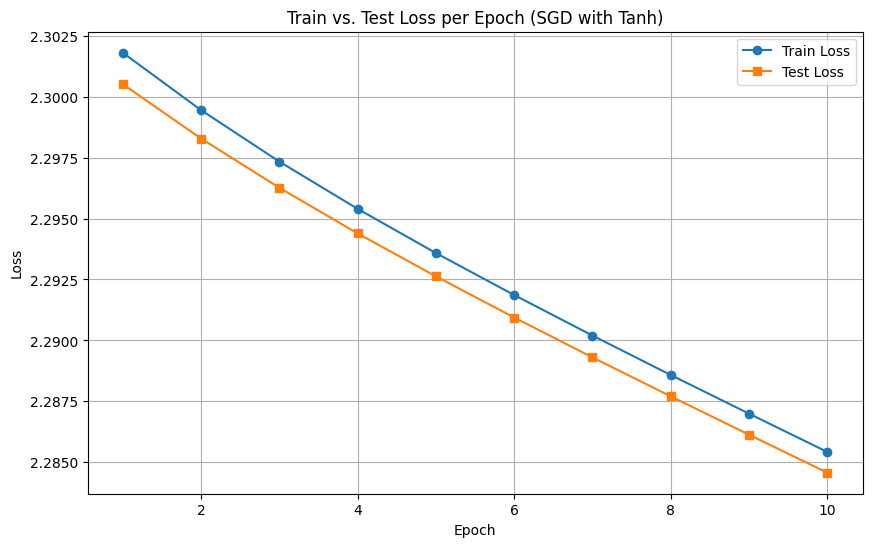

In [29]:
# Plotting Train and Test Loss Curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_loss_history, marker='o', linestyle='-', label="Train Loss")
plt.plot(range(1, num_epochs + 1), test_loss_history, marker='s', linestyle='-', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs. Test Loss per Epoch (SGD with Tanh)")
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Report final test accuracy
final_accuracy = test_accuracy_history[-1]
print(f"\nFinal Test Accuracy with SGD and Tanh: {final_accuracy:.2f}%")


Final Test Accuracy with SGD and Tanh: 15.58%


Run in terminal 

tensorboard --logdir=runs

Change the optimizer to Adam 

In [31]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [32]:
# Setup TensorBoard writer (logs will be saved in 'runs/adam_tanh_experiment')
writer = SummaryWriter('runs/adam_tanh_experiment')

# Lists to record loss and accuracy per epoch (optional for plotting)
train_loss_history = []
test_loss_history = []
test_accuracy_history = []

# Training loop with evaluation and TensorBoard logging
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * images.size(0)
    
    epoch_train_loss = running_train_loss / len(train_dataset)
    train_loss_history.append(epoch_train_loss)
    writer.add_scalar('Loss/train', epoch_train_loss, epoch)
    
    # Evaluation phase
    model.eval()
    running_test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_test_loss = running_test_loss / len(test_dataset)
    test_loss_history.append(epoch_test_loss)
    test_accuracy = 100 * correct / total
    test_accuracy_history.append(test_accuracy)
    
    writer.add_scalar('Loss/test', epoch_test_loss, epoch)
    writer.add_scalar('Accuracy/test', test_accuracy, epoch)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, "
          f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

writer.close()

Epoch [1/10], Train Loss: 1.7789, Test Loss: 1.5749, Test Accuracy: 45.12%
Epoch [2/10], Train Loss: 1.5183, Test Loss: 1.4532, Test Accuracy: 49.10%
Epoch [3/10], Train Loss: 1.4051, Test Loss: 1.3552, Test Accuracy: 52.56%
Epoch [4/10], Train Loss: 1.3204, Test Loss: 1.2864, Test Accuracy: 54.78%
Epoch [5/10], Train Loss: 1.2537, Test Loss: 1.2425, Test Accuracy: 55.94%
Epoch [6/10], Train Loss: 1.1976, Test Loss: 1.1863, Test Accuracy: 58.40%
Epoch [7/10], Train Loss: 1.1529, Test Loss: 1.1607, Test Accuracy: 59.26%
Epoch [8/10], Train Loss: 1.1146, Test Loss: 1.1305, Test Accuracy: 60.36%
Epoch [9/10], Train Loss: 1.0786, Test Loss: 1.0994, Test Accuracy: 61.63%
Epoch [10/10], Train Loss: 1.0456, Test Loss: 1.0837, Test Accuracy: 62.15%


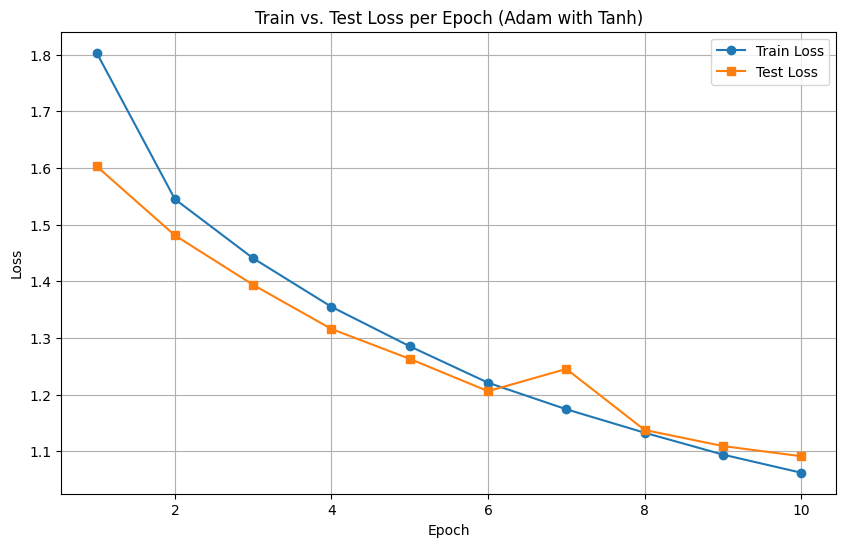

In [19]:
# Plotting Train and Test Loss Curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_loss_history, marker='o', linestyle='-', label="Train Loss")
plt.plot(range(1, num_epochs + 1), test_loss_history, marker='s', linestyle='-', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs. Test Loss per Epoch (Adam with Tanh)")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Report final test accuracy
final_accuracy = test_accuracy_history[-1]
print(f"\nFinal Test Accuracy with Adam and Tanh: {final_accuracy:.2f}%")


Final Test Accuracy with Adam and Tanh: 61.74%


Run in terminal 

tensorboard --logdir=runs

Tanh activations tend to compress values into a narrow range and can suffer from very small (or “vanishing”) gradients when inputs are large. Adam’s adaptive learning mechanism can compensate for this by dynamically adjusting the learning rates for different parameters, effectively boosting small gradients. This helps a Tanh-based network learn better when trained with Adam.

In contrast, LeakyReLU always provides a small, nonzero gradient for negative inputs, which makes its gradient flow more consistent. This steady behavior means that even with the simpler update rules of SGD, LeakyReLU can still propagate useful gradients.

So, in our experiments, Tanh worked much better with Adam because Adam’s adjustments helped overcome Tanh’s tendency to saturate, while LeakyReLU, with its inherent gradient robustness, showed slightly better performance with SGD.